<a href="https://colab.research.google.com/github/R-HUA/COMP90086-project/blob/main/%E2%80%9CCOMP90086_ipynb%E2%80%9D.ipynb" target="_parent"></a>

### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Project

## Import Libraries

In [1]:
import os
import math
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
import threading
global THREAD_NUM 

## Load sample images

In [2]:
# read the photos and disparity maps in the folder and save them in
# a dictionary indexed by the file name

cwd = os.getcwd()
data_set = cwd +"/Dataset"

file_names = os.listdir(data_set)

imgs = {}
ground_truth = {}
for i in range(len(file_names)):
    if file_names[i].endswith('.jpg'):
        fname = file_names[i][:43]
        ftype = file_names[i][-4:]
        imgs[fname] = [cv2.imread(data_set + '/' + fname  + '-left.jpg',cv2.IMREAD_GRAYSCALE), cv2.imread(data_set + '/' + fname  + '-right.jpg',cv2.IMREAD_GRAYSCALE)]
        ground_truth[fname] = cv2.imread(data_set + '/' + fname  + '-disparity.png', -1)  # 16bit png

## Show sample image

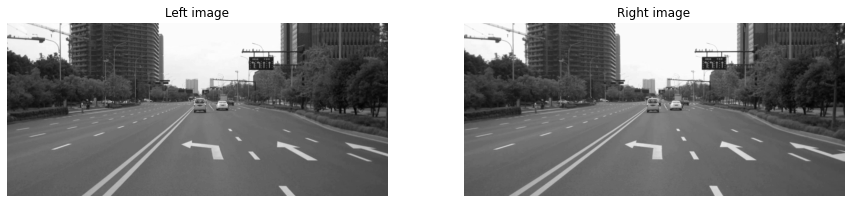

In [3]:
# Show images
img_name = "2018-07-09-16-11-56_2018-07-09-16-11-56-702"
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(imgs[img_name][0], cmap='gray')  
plt.title("Left image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(imgs[img_name][1], cmap='gray')  
plt.title("Right image")
plt.axis('off')

plt.show() 

# Question 1
To calculate a disparity map for the left image using classical (non deep learning) methods

## Sum of Squared Differences (SSD)

In [14]:
global SEARCH_BLOCK_SIZE
SEARCH_BLOCK_SIZE = 32
THREAD_NUM = 2
# thread function
def ssd_(st,end,imgL,imgR,window_size,disparity):
    width, height = imgL.shape[:2]

    for i in range(st,end):
      for j in range(window_size//2, height-window_size//2):
          min_ssd = float('inf')
          for k in range(SEARCH_BLOCK_SIZE):
            if j-k < window_size//2:
              break
            ssd = np.sum((imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1] - imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k])**2)
  
            if ssd < min_ssd:
              min_ssd = ssd
              disparity[i,j] = k 


def ssd(imgL,imgR,window_size):
  width, height = imgL.shape[:2] 
  d = np.zeros((width, height), np.uint16)
  st = window_size//2
  end = width-window_size//2
  chunk = math.ceil((end - st) / THREAD_NUM)
  thread_list = []
  for treadno in range(THREAD_NUM):
    i_end = min((st + chunk * (treadno+1),end))
    t = threading.Thread(target=ssd_,args=((st + chunk * treadno),i_end,imgL,imgR,window_size,d))
    t.start()
    thread_list.append(t)
  for i in range(len(thread_list)):
    thread_list[i].join()
  return d

## Normalized Cross Correlation (NCC)

In [4]:
def ncc(imgL,imgR,window_size):
    width, height = imgL.shape[:2]
    disparity = np.zeros((width, height), np.uint8)

    for i in tqdm(range(window_size//2, width-window_size//2)):
        for j in range(window_size//2, height-window_size//2):
            max_ncc = -1
            for k in range(SEARCH_BLOCK_SIZE):
                if j-k < window_size//2:
                    break
                ncc = np.sum((imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1] - np.mean(imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1])) * (imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k] - np.mean(imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k]))) / (np.sqrt(np.sum((imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1] - np.mean(imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1]))**2)) * np.sqrt(np.sum((imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k] - np.mean(imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k]))**2)))
                if ncc > max_ncc:
                    max_ncc = ncc
                    disparity[i,j] = k
    return disparity

## Sum of Absolute Differences (SAD)

In [13]:
# thread function
def sad_(st,end,imgL,imgR,window_size,disparity):
    width, height = imgL.shape[:2]

    for i in range(st,end):
      for j in range(window_size//2, height-window_size//2):
          min_ssd = float('inf')
          for k in range(SEARCH_BLOCK_SIZE):
            if j-k < window_size//2:
              break
            ssd = np.sum(np.abs((imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1] - imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k])))

            if ssd < min_ssd:
              min_ssd = ssd
              disparity[i,j] = k


def sad(imgL,imgR,window_size):
  width, height = imgL.shape[:2]
  d = np.zeros((width, height), np.uint16)
  st = window_size//2
  end = width-window_size//2
  chunk = math.ceil((end - st) / THREAD_NUM)
  thread_list = []
  for treadno in range(THREAD_NUM):
    i_end = min((st + chunk * (treadno+1),end))
    t = threading.Thread(target=sad_,args=((st + chunk * treadno),i_end,imgL,imgR,window_size,d))
    t.start()
    thread_list.append(t)
  for i in range(len(thread_list)):
    thread_list[i].join()
  return d

# Question 2

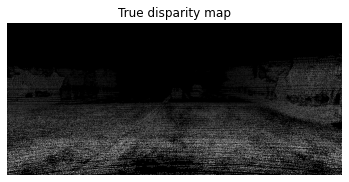

In [6]:
# Show images
plt.imshow(ground_truth[img_name], cmap='gray')  
plt.title("True disparity map")
plt.axis('off')

plt.show() 

## Errors

In [8]:
def errors(img_truth,estimated_disparity):
  avliable_pixels = np.where(img_truth != 0)
  errors = np.abs(img_truth[avliable_pixels]-estimated_disparity[avliable_pixels])
  # root mean square error
  rms = np.sqrt(np.mean(errors **2))
  # percentage of errors by pixels
  errors4 = np.where(errors < 4)[0].shape[0]/avliable_pixels[0].shape[0] 
  errors2 = np.where(errors < 2)[0].shape[0]/avliable_pixels[0].shape[0] 
  errors1 = np.where(errors < 1)[0].shape[0]/avliable_pixels[0].shape[0] 
  errors0_5 = np.where(errors< 0.5)[0].shape[0]/avliable_pixels[0].shape[0] 
  errors0_25 = np.where(errors < 0.25)[0].shape[0]/avliable_pixels[0].shape[0] 

  return rms, (errors4,errors2,errors2,errors0_5,errors0_25)


### the runtime and erros by using ssd

2018-07-09-16-11-56_2018-07-09-16-11-56-702
run time: 95.23488092422485
(20.546817298417995, (0.48918308772646313, 0.4136859181612951, 0.4136859181612951, 0.19991151346016403, 0.10997288681664001))


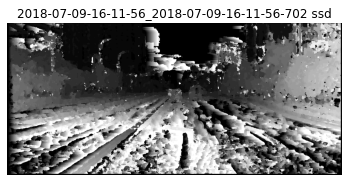

In [15]:
THREAD_NUM = 1
print(img_name)
start = time.time()
ssd_dmap = ssd(imgs[img_name][0],imgs[img_name][1],7)
ssd_errors = errors(ground_truth[img_name]/256,ssd_dmap)
ssd_run_time = time.time() - start
print("run time:",ssd_run_time)
print(ssd_errors)
plt.imshow(ssd_dmap, cmap='gray')
plt.title(img_name + " ssd")
plt.axis('off')

plt.show()


### errors and runtime by using SAD

run time: 84.91701912879944
(23.574508547850982, (0.2130483612973488, 0.14189610772669004, 0.14189610772669004, 0.052592769061475454, 0.026670750660812943))


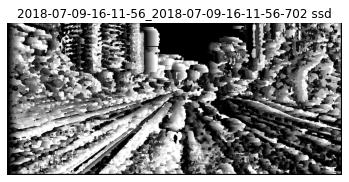

In [17]:
start = time.time()
sad_dmap = sad(imgs[img_name][0],imgs[img_name][1],7)
sad_errors = errors(ground_truth[img_name]/256,sad_dmap)
sad_run_time = time.time() - start
print("run time:",sad_run_time)
print(sad_errors)
plt.imshow(sad_dmap, cmap='gray')
plt.title(img_name + " ssd")
plt.axis('off')
plt.show()

### errors and runtime by using NCC

In [ ]:
start = time.time()
img_name = "2018-07-09-16-11-56_2018-07-09-16-11-56-702"
d_ncc = ncc(imgs[img_name][0],imgs[img_name][1],7)
ncc_run_time = time.time() - start
ncc_errors = errors(ground_truth[img_name]/256,d_ncc)

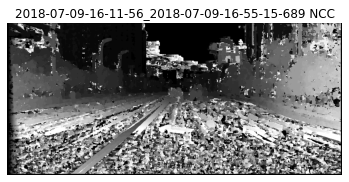

In [78]:
plt.imshow(d_ncc, cmap='gray')
plt.title(img_name + " NCC")
plt.axis('off')

plt.show()

In [29]:
print("run_time:", ncc_run_time)
print("(rmse,(<4,<2,<1,<0.5,<0.25)):",ncc_errors)

run_time: 977.4527945518494
(rmse,(<4,<2,<1,<0.5,<0.25)): (18.468195777946868, (0.5016733031571544, 0.4306344938683366, 0.4306344938683366, 0.21658782289078718, 0.11937741778125674))


# Test the window size

In [ ]:
e = [[] for _ in range(3,27,4)]
run_time = [-1 for _ in range(3,27,4)]
for size in tqdm(range(3,27,4)):
  for img_name in imgs.keys():
    start_time = time.time()

    d = ssd(imgs[img_name][0],imgs[img_name][1],size)
    e[(size-3)//4].append(errors(ground_truth[img_name]/256,d))

    end_time = time.time()
    run_time[(size-3)//4] += (end_time - start_time)

100%|██████████| 6/6 [1:21:15<00:00, 812.63s/it]


In [ ]:
for size in range(3,27,4):
    for j in range(len(list(imgs.keys()))):
        print("img",list(imgs.keys())[j]," window size: ", size)
        print("rms:",e[(size-3)//4][j][0])
        print("error (<4 <2 <1 <0.5 <0.25):", e[(size-3)//4][j][1])
        print()



img 2018-07-09-16-11-56_2018-07-09-16-11-56-702  window size:  3
rms: 20.452459727962456
error (<4 <2 <1 <0.5 <0.25): (0.5549127046251233, 0.462137970935575, 0.462137970935575, 0.21750672157369907, 0.12273536852374956)

img 2018-07-09-16-11-56_2018-07-09-16-41-23-475  window size:  3
rms: 20.140329963752052
error (<4 <2 <1 <0.5 <0.25): (0.5061370924947511, 0.42416307131486053, 0.42416307131486053, 0.18448192326327204, 0.10428442885817779)

img 2018-07-09-16-11-56_2018-07-09-16-42-22-318  window size:  3
rms: 26.347388402319705
error (<4 <2 <1 <0.5 <0.25): (0.4586234549828791, 0.39380592930154407, 0.39380592930154407, 0.18162145648493488, 0.09036520322305529)

img 2018-07-09-16-11-56_2018-07-09-16-46-01-859  window size:  3
rms: 26.168827281545315
error (<4 <2 <1 <0.5 <0.25): (0.4895003913735863, 0.44790682609517124, 0.44790682609517124, 0.26854975842802775, 0.13359334934816056)

img 2018-07-09-16-11-56_2018-07-09-16-46-51-712  window size:  3
rms: 18.510407615866093
error (<4 <2 <1 <0.

In [ ]:
run= np.array(run_time) / len(imgs.keys())

for i in range(3,27,4):
  print("window size:",i)
  print("mean run_time:",run[(i-3)//4])
  rms = 0
  err = np.zeros(5)
  for j in range(len(list(imgs.keys()))):
      rms += e[(i-3)//4][j][0]
      err += np.array(e[(i-3)//4][j][1])
  print("mean rms: %.2f"%(rms/ len(imgs.keys())))
  print("mean error [<4 <2 <1 <0.5 <0.25] pixels:", err/ len(imgs.keys()))
  print()

window size: 3
mean run_time: 93.66906666755676
mean rms: 25.00
mean error [<4 <2 <1 <0.5 <0.25] pixels: [0.36923025 0.29146965 0.29146965 0.12455733 0.06528892]

window size: 7
mean run_time: 92.30584856442044
mean rms: 24.60
mean error [<4 <2 <1 <0.5 <0.25] pixels: [0.4634196  0.40294793 0.40294793 0.20402526 0.10749688]

window size: 11
mean run_time: 85.81959029606409
mean rms: 24.56
mean error [<4 <2 <1 <0.5 <0.25] pixels: [0.49741891 0.44318741 0.44318741 0.23297913 0.12303517]

window size: 15
mean run_time: 90.91300364903041
mean rms: 24.57
mean error [<4 <2 <1 <0.5 <0.25] pixels: [0.51184032 0.4561857  0.4561857  0.24252908 0.12806074]

window size: 19
mean run_time: 93.69968795776367
mean rms: 24.62
mean error [<4 <2 <1 <0.5 <0.25] pixels: [0.51787193 0.45635644 0.45635644 0.24324176 0.1287292 ]

window size: 23
mean run_time: 239.27659722736902
mean rms: 24.70
mean error [<4 <2 <1 <0.5 <0.25] pixels: [0.51913608 0.45058767 0.45058767 0.23960393 0.12671653]



### mean rmse by window size

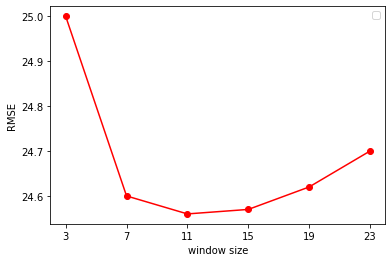

In [76]:
x1 = [ str(i) for i in range(3,27,4)]
y1 = rms/ len(imgs.keys())
plt.plot(x1,y1,'ro-')
plt.xlabel('window size')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
test_i = list(imgs.keys())[-4:]
e = [[] for _ in range(3,27,4)]
run_time = [-1 for _ in range(3,27,4)]
for size in tqdm(range(3,27,4)):
  for img_name in test_i:
    start_time = time.time()

    d = ncc(imgs[img_name][0],imgs[img_name][1],size)
    e[(size-3)//4].append(errors(ground_truth[img_name]/256,d))

    end_time = time.time()
    run_time[(size-3)//4] += (end_time - start_time)

run= np.array(run_time) / len(test_i)

for i in range(3,27,4):
  print("window size:",i)
  print("mean run_time:",run[(i-3)//4])
  rms = 0
  err = np.zeros(5)
  for j in range(len(test_i)):
      rms += e[(i-3)//4][j][0]
      err += np.array(e[(i-3)//4][j][1])
  print("mean rms: %.2f"%(rms/ len(imgs.keys())))
  print("mean error [<4 <2 <1 <0.5 <0.25] pixels:", err/ len(imgs.keys()))
  print()

#### In summary, when the window size is 11, the overall performance is the best

# improvements

#### NCC with bilateral filter

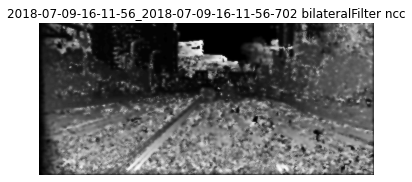

When using bilateralFilter can significantly reduces errors.
rms error is 12.728
percentage number of errors less than 4 pixels: 0.4839759951899624
percentage number of errors less than 2 pixels: 0.3256191221681471
percentage number of errors less than 2 pixels: 0.3256191221681471
percentage number of errors less than 0.5 pixels: 0.10431201715277541
percentage number of errors less than 0.25 pixels: 0.05379527844898978


In [ ]:
x = cv2.bilateralFilter(d_ncc,11,35,35)
plt.imshow(x, cmap='gray')
plt.title(img_name + " bilateralFilter ncc")
plt.axis('off')

plt.show()

bf_rms,bf_errorlessthan = errors(ground_truth[img_name]/256,x)

print("When using bilateralFilter can significantly reduces errors.","rms error is %.3f"%bf_rms)
print("percentage number of errors less than 4 pixels:",bf_errorlessthan[0])
print("percentage number of errors less than 2 pixels:",bf_errorlessthan[1])
print("percentage number of errors less than 2 pixels:",bf_errorlessthan[2])
print("percentage number of errors less than 0.5 pixels:",bf_errorlessthan[3])
print("percentage number of errors less than 0.25 pixels:",bf_errorlessthan[4])

### SSD with bilateral filter

run_time: 94.45276522636414
(19.86675486327151, (0.4920418836288557, 0.41348171845398135, 0.41348171845398135, 0.19867497078809743, 0.11027918637761064))


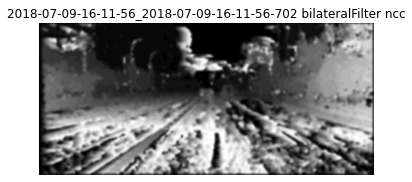

In [9]:
st = time.time()

x = cv2.bilateralFilter(ssd_dmap.astype(np.uint8),11,35,35)
xe = errors(ground_truth[img_name]/256,x)

x_time = ssd_run_time + time.time() - st

print("run_time:",x_time)
print(xe)
plt.imshow(x, cmap='gray')
plt.title(img_name + " bilateralFilter ncc")
plt.axis('off')

plt.show()


# Sub­pixel estimation

In [34]:
SEARCH_BLOCK_SIZE = 32
THREAD_NUM = 1

def spssd_(st,end,imgL,imgR,window_size,disparity):
    width, height = imgL.shape[:2]

    for i in tqdm(range(st,end)):
      for j in range(window_size//2, height-window_size//2):
          ssd_k = []
          for k in range(SEARCH_BLOCK_SIZE):
            if j-k < window_size//2:
              break
            ssd = np.sum((imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1] - imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k])**2)
  
            ssd_k.append([ssd,k])
            ssd_k.sort()
            ssd_k = ssd_k[:3]
          if len(ssd_k) >= 3:
            ssd_k.sort()
            k_min = ssd_k[0][1]
            ssd_min = ssd_k[0][0]
            lb = None
            ls = None
            for t in ssd_k:
              if lb is None or ls is None:
                if t[1] > k_min and lb is None:
                  lb = t[0]
                elif t[1] < k_min and ls is None:
                  ls = t[0]
            if lb is None or ls is None:
              disparity[i,j] = ssd_k[0][1] * 256
            else:
              disparity[i,j] = (k_min - 0.5 * (lb - ls)/(ls - 2 * ssd_min + lb)) * 256
          else:
            disparity[i,j] = ssd_k[0][1] * 256



def subpixel_ssd(imgL,imgR,window_size):
  width, height = imgL.shape[:2] 
  d = np.zeros((width, height), np.uint16)
  st = window_size//2
  end = width-window_size//2
  chunk = math.ceil((end - st) / THREAD_NUM)
  thread_list = []
  for treadno in range(THREAD_NUM):
    i_end = min((st + chunk * (treadno+1),end))
    #t = threading.Thread(target=ssd_,args=((st + chunk * treadno),i_end,imgL,imgR,window_size,d))
    spssd_((st + chunk * treadno),i_end,imgL,imgR,window_size,d)
    #t.start()
    #thread_list.append(t)
  for i in range(len(thread_list)):
    thread_list[i].join()
  return d


In [ ]:
start_time = time.time()
width, height = imgs[fname][0].shape[:2]
sp_dmap = subpixel_ssd(imgs[fname][0],imgs[fname][1],13)
end_time = time.time()
sp_run_time = end_time - start_time
sp_err = errors(ground_truth[fname]/256,sp_dmap/256)

In [39]:
print(sp_run_time)

print(sp_err)

97.81930637359619
(23.77942265876921, (0.34200047646598375, 0.28350860474877765, 0.28350860474877765, 0.1372675810275783, 0.0770740450827576))


# Image Pyramid

In [13]:
img_name = "2018-07-09-16-11-56_2018-07-09-16-11-56-702"

def pyramid(imgL,imgR,method):
  start = time.time()
  SEARCH_BLOCK_SIZE = 16

  rows, cols = map(int, imgL.shape)
  pyrl = cv2.pyrDown(imgL, dstsize=(cols // 2, rows // 2))
  pyrr = cv2.pyrDown(imgR, dstsize=(cols // 2, rows // 2))


  pyrd = method(pyrl,pyrr,3)
  d = cv2.pyrUp(pyrd)

  d = cv2.bilateralFilter(d.astype(np.uint8),11,35,35)
  d = np.r_[d,np.zeros((rows - d.shape[0],d.shape[1]))]
  d = np.c_[d,np.zeros((d.shape[0],cols - d.shape[1]))]
  return d,(time.time() - start),errors(ground_truth[img_name]/256,d)


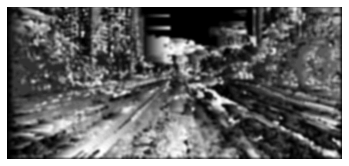

(22.61324721020996, (0.13453357383521083, 0.06272334342987441, 0.06272334342987441, 0.014657001213853816, 0.007566733598792953))
run time: 20.918052673339844


In [14]:
p_dmap,p_run_time,p_errs = pyramid(imgs[img_name][0],imgs[img_name][1],ssd)

plt.imshow(p_dmap * 5, cmap='gray')
plt.axis('off')
plt.show()
print(p_errs)
print("run time:", p_run_time)

  0%|          | 0/198 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 198/198 [04:11<00:00,  1.27s/it]


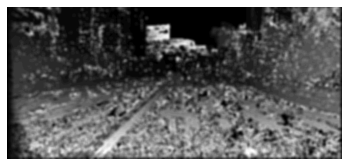

(20.544629115934296, (0.1546132117210632, 0.06771489183087727, 0.06771489183087727, 0.016835131425200513, 0.007986477441604556))
run time: 251.87717700004578


In [34]:
dmap,run_time,errs = pyramid(imgs[img_name][0],imgs[img_name][1],ncc)

plt.imshow(dmap * 5, cmap='gray')
plt.axis('off')
plt.show()
print(errs)
print("run time:", run_time)

100%|██████████| 194/194 [00:22<00:00,  8.45it/s]


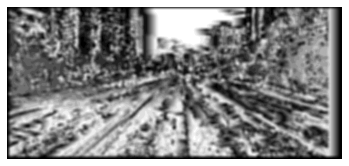

(24.88879801294612, (0.10338177404167943, 0.048724319050698246, 0.048724319050698246, 0.011854927452381763, 0.006398257495830922))
run time: 23.002644300460815


In [46]:
dmap,run_time,errs = pyramid(imgs[img_name][0],imgs[img_name][1],sad)

plt.imshow(dmap * 5, cmap='gray')
plt.axis('off')
plt.show()
print(errs)
print("run time:", run_time)


### SSD & image pyramid with all images

In [65]:
basic_results_run_time = []
improved_results_run_time = []

basic_results_rmse = []
improved_results_rmse = []

basic_results_errors = []
improved_results_errors = []

img_list = list(imgs.keys())

for img_name in (img_list):
  start = time.time()

  basic_result = ssd(imgs[img_name][0],imgs[img_name][1],11)

  basic_results_rmse.append(errors(ground_truth[img_name]/256,basic_result)[0])

  basic_results_errors.append(errors(ground_truth[img_name]/256,basic_result)[1][0])

  basic_results_run_time.append(time.time() - start)
  
  dmap,run_time,errs = pyramid(imgs[img_name][0],imgs[img_name][1],ssd)

  improved_results_rmse.append(errs[0])

  improved_results_errors.append(errs[1][0])

  improved_results_run_time.append(run_time)






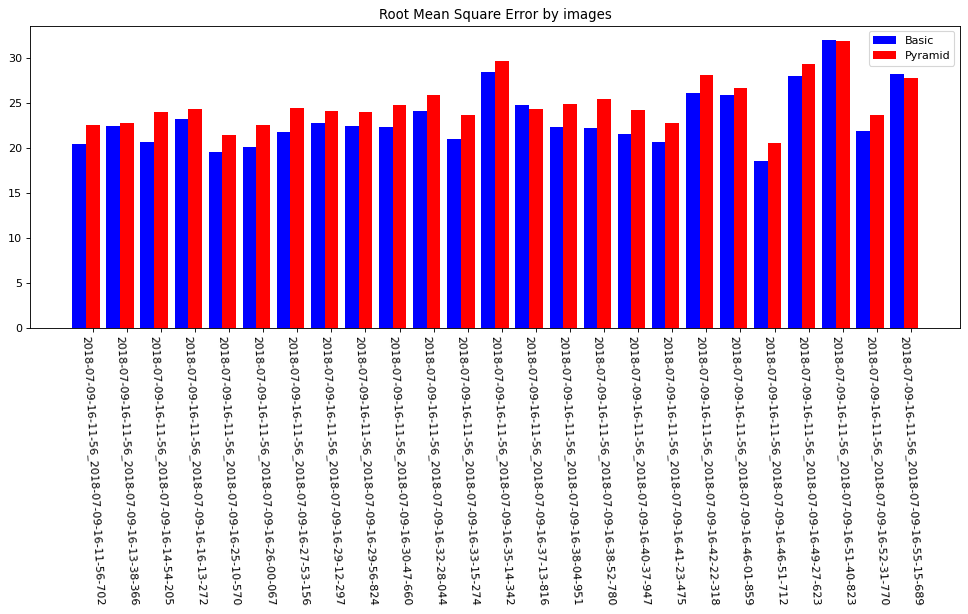

In [66]:
x = list(range(len(img_list)))
width = 0.4
plt.figure(figsize=(15, 5), dpi=80)
plt.bar(x,basic_results_rmse,width = width, label = 'Basic', fc = 'b')
for i in range(len(x)):
  x[i] += width
plt.bar(x,improved_results_rmse,width = width, label = 'Pyramid',tick_label = img_list ,fc = 'r')
plt.legend()
plt.title('Root Mean Square Error by images')
plt.xticks(rotation=273)
plt.show()

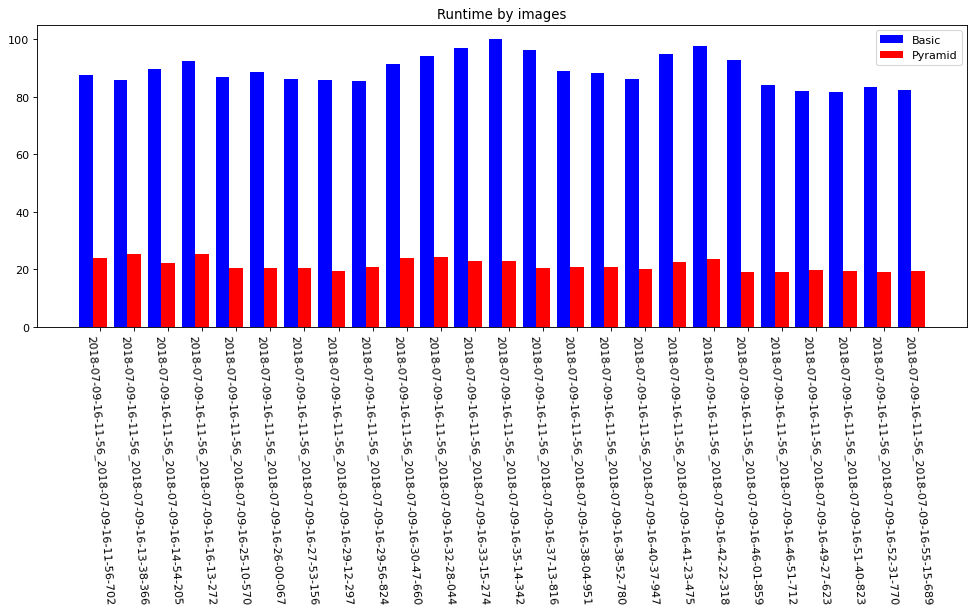

In [67]:
x = list(range(len(img_list)))
width = 0.4
plt.figure(figsize=(15, 5), dpi=80)
plt.bar(x,basic_results_run_time,width = width, label = 'Basic', fc = 'b')
for i in range(len(x)):
  x[i] += width
plt.bar(x,improved_results_run_time,width = width, label = 'Pyramid',tick_label = img_list ,fc = 'r')
plt.legend()
plt.xticks(rotation=274)
plt.title('Runtime by images')
plt.show()

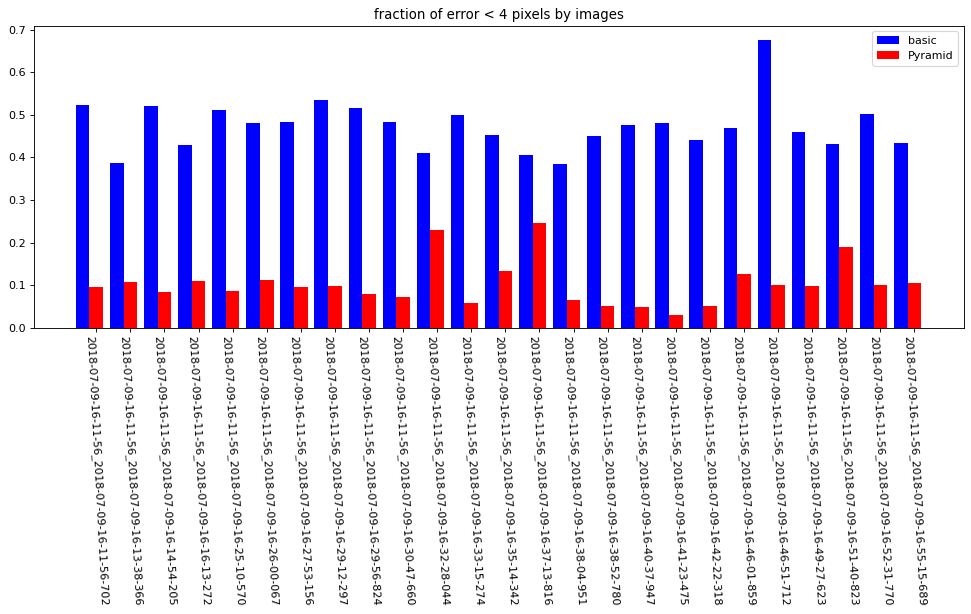

In [68]:
x = list(range(len(img_list)))
width = 0.4
plt.figure(figsize=(15, 5), dpi=80)
plt.bar(x,basic_results_errors,width = width, label = 'basic', fc = 'b')
for i in range(len(x)):
  x[i] += width
plt.bar(x,improved_results_errors,width = width, label = 'Pyramid',tick_label = img_list ,fc = 'r')
plt.legend()
plt.title('fraction of error < 4 pixels by images')
plt.xticks(rotation=273)
plt.show()

##  Summary of results

In [15]:
import pandas as pd

print(img_name)
start = time.time()
wd_dmap = ssd(imgs[img_name][0],imgs[img_name][1],11)
wd_errors = errors(ground_truth[img_name]/256,ssd_dmap)
wd_run_time = time.time() - start


2018-07-09-16-11-56_2018-07-09-16-11-56-702


In [ ]:
data = [["Basic block matching (BBM) using SSD",ssd_errors[0],ssd_errors[1][0],ssd_run_time],["BBM + optimal window size",wd_errors[0],wd_errors[1][0],wd_run_time],["BBM + sub_pixel est",sp_err[0],sp_err[1][0],sp_run_time],["BBM + Image pyramid",p_errs[0],p_errs[1][0],p_run_time],["SSD with bilateral filter",xe[0],xe[1][0],x_time]]

df = pd.DataFrame(data,columns=['','rmse','fraction of error < 4','run time'],dtype=float)

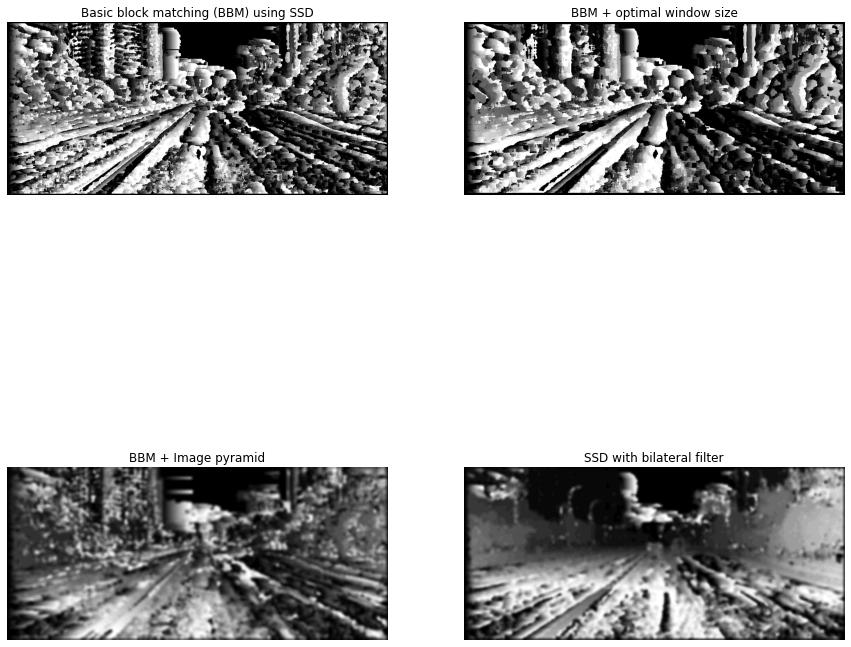

In [18]:
plt.subplots(figsize=(15, 15))

plt.subplot(2,2,1)
plt.imshow(ssd_dmap, cmap='gray')
plt.title("Basic block matching (BBM) using SSD")
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(wd_dmap, cmap='gray')
plt.title("BBM + optimal window size")
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(p_dmap, cmap='gray')
plt.title("BBM + Image pyramid")
plt.axis('off')


plt.subplot(2,2,4)
plt.imshow(x, cmap='gray')
plt.title("SSD with bilateral filter")
plt.axis('off')

plt.show()

In [85]:
df

,,rmse,fraction of error < 4,run time
0,Basic block matching (BBM) using SSD,20.642257,0.455320,85.984982
1,BBM + optimal window size,20.546817,0.489183,89.684088
2,BBM + sub_pixel est,23.779423,0.342000,97.819306
3,BBM + Image pyramid,22.617576,0.095974,21.460588
4,SSD with bilateral filter,29.073464,0.160857,89.973335
